# Analysis of CHM13v2 alignment and variant calling

## Set-up

### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import numpy as np
import gzip
import warnings
warnings.filterwarnings( "ignore", module = "seaborn\..*" )

### Set project directory

In [2]:
projectDir = '/home/jupyter/CHM13v2_analysis'
dataDir = f'{projectDir}/data'
figDir = f'{projectDir}/figures'

### Download Data

### Set plotting parameters

In [3]:
mm = 1/25.4
plt.rcParams['figure.figsize'] = [48*mm, 32*mm]
plt.rcParams['svg.fonttype'] = 'path'
plt.style.use('ggplot')

production_size=5

font = fm.FontEntry(fname=f'{projectDir}/Helvetica.ttf', size=5.0, name='Helvetica')
fm.fontManager.ttflist.insert(0, font)
plt.rcParams['font.family'] = font.name
plt.rc('font', size=production_size)          # controls default text sizes
plt.rc('axes', titlesize=6)     # fontsize of the axes title
plt.rc('axes', labelsize=production_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=production_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=production_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=production_size/4)    # legend fontsize
plt.rc('figure', titlesize=6)  # fontsize of the figure title
plt.rcParams['lines.linewidth'] = 0.3
plt.rcParams['xtick.major.width'] = 0.2
plt.rcParams['xtick.minor.width'] = 0.2
plt.rcParams['ytick.major.width'] = 0.2
plt.rcParams['ytick.minor.width'] = 0.2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['xtick.minor.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['ytick.minor.pad'] = 1
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['grid.linewidth'] = 0.2
plt.rcParams['lines.markersize'] = 0.8
plt.rcParams['lines.markeredgewidth'] = 0.3
plt.rcParams['boxplot.flierprops.markersize'] = 0.8
plt.rcParams['boxplot.flierprops.markeredgewidth'] = 0.3
plt.rcParams['boxplot.flierprops.linewidth'] = 0.3

flierprops = dict(marker='o', markerfacecolor='None', markersize=1,  markeredgecolor='black', markeredgewidth=0.3)

chm13_v1_color = '#FF7F0E'
chm13_v2_color = '#BA324F'
genome_palette = {'CHM13v1': chm13_v1_color, 'CHM13v2': chm13_v2_color, 'GRCh38': chm13_v1_color}

AFR_color = 'tab:cyan'
AMR_color = 'tab:orange'
EAS_color = 'tab:pink'
EUR_color = 'tab:blue'
SAS_color = 'tab:cyan'
superpop_palette = {'AFR': AFR_color,
                    'AMR': AMR_color,
                    'EAS': EAS_color,
                    'EUR': EUR_color,
                    'SAS': SAS_color}

### Read-in sample info

In [4]:
sample_info_file = f"{dataDir}/1KGP_sample_info.txt.gz"
sample_info_df = pd.read_csv(sample_info_file, sep='\t', header=0, index_col=0)
sample_info_df

,karyotype,superpopulation,population,Y_haplogroup,unrelated
1KGP_sample_id,,,,,
HG00096,XY,EUR,GBR,R1b,True
HG00097,XX,EUR,GBR,None,True
HG00099,XX,EUR,GBR,None,True
HG00100,XX,EUR,GBR,None,True
HG00101,XY,EUR,GBR,I1,True
...,...,...,...,...,...
NA21137,XX,SAS,GIH,None,True
NA21141,XX,SAS,GIH,None,True
NA21142,XX,SAS,GIH,None,True


In [5]:
unrelated_samples = list(sample_info_df.loc[sample_info_df['unrelated']==True].index)
XY_unrelated_samples = list(sample_info_df.loc[(sample_info_df['unrelated']==True) & (sample_info_df['karyotype']=='XY')].index)
XX_unrelated_samples = list(sample_info_df.loc[(sample_info_df['unrelated']==True) & (sample_info_df['karyotype']=='XX')].index)


# chrY Alignment Statistics

Y chromosome alignment statistics were generated for each unrelated XY sample separately. Individual sample statistics were then merged into a single file. The command to generate chrY stats for a single sample is as follows: `samtools stats -r CHM13v2.0.XY.fasta --reference CHM13v2.0.XY.fasta -X {sample}.cram {sample}.cram.crai chrY`.

In [6]:
# Get a dataframe with chrY alignment statistics for unrelated XY samples
def cramstatsDF(file_name, ref):
    cramstats_df = pd.read_csv(file_name, sep='\t', header=0, index_col=0)
    cramstats_df = cramstats_df.loc[XY_unrelated_samples]
    cramstats_df['Superpopulation'] = sample_info_df.loc[XY_unrelated_samples, 'superpopulation']
    cramstats_df['ref'] = ref
    cramstats_df['reads mapped scaled'] = cramstats_df['reads mapped']/1_000_000
    cramstats_df['error rate (%)'] = cramstats_df['error rate'] * 100
    
    return cramstats_df

In [7]:
def printCramStats(stat, CHM13v1DF, CHM13v2DF):
    
    CHM13v1_reads_mapped = CHM13v1DF[stat]
    CHM13v2_reads_mapped = CHM13v2DF[stat]
    delta_reads_mapped = CHM13v2DF[stat] - CHM13v1DF[stat]

    print(f'CHM13v1 mean reads mapped {stat}:', np.mean(CHM13v1_reads_mapped))
    print(f'CHM13v1 stddev reads mapped {stat}:', np.std(CHM13v1_reads_mapped))
    print('')
    print(f'CHM13v2 mean reads mapped {stat}:', np.mean(CHM13v2_reads_mapped))
    print(f'CHM13v2 stddev reads mapped {stat}:', np.std(CHM13v2_reads_mapped))
    print('')
    print(f'CHM13v2 - CHM13v1 mean {stat}:', np.mean(delta_reads_mapped))
    print(f'CHM13v2 - CHM13v1 stddev {stat}:', np.std(delta_reads_mapped))

In [8]:
CHM13v1_full_cramstats_file = f"{dataDir}/cramstats/CHM13v1_stats.all.txt" # This file has stats for all 3202 samples, full chromosome, no PAR
CHM13v2_full_cramstats_file = f"{dataDir}/cramstats/CHM13v2_stats.all.txt" # This file has stats for all 3202 samples, full chromosome, no PAR

CHM13v1_full_cramstats_df = cramstatsDF(CHM13v1_full_cramstats_file, 'CHM13v1')
CHM13v2_full_cramstats_df = cramstatsDF(CHM13v2_full_cramstats_file, 'CHM13v2')

## chrY Full (full chromosome, no PAR, unrelated samples only)

In [9]:
full_cramstats_df = pd.concat([CHM13v1_full_cramstats_df, CHM13v2_full_cramstats_df], axis=0)
full_cramstats_df_copy = full_cramstats_df.copy()
full_cramstats_df_copy['Superpopulation'] = 'ALL'
full_cramstats_df = pd.concat([full_cramstats_df, full_cramstats_df_copy], axis=0)

### Reads Mapped

#### Stats summary

In [10]:
stat = 'reads mapped'
printCramStats(stat, CHM13v1_full_cramstats_df, CHM13v2_full_cramstats_df)

CHM13v1 mean reads mapped reads mapped: 5012971.00405515
CHM13v1 stddev reads mapped reads mapped: 745339.8381239614

CHM13v2 mean reads mapped reads mapped: 6396203.642335766
CHM13v2 stddev reads mapped reads mapped: 1120238.0908331873

CHM13v2 - CHM13v1 mean reads mapped: 1383232.6382806164
CHM13v2 - CHM13v1 stddev reads mapped: 432115.22462021967


#### Plotting

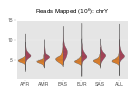

In [11]:
ax = sns.violinplot(x = "Superpopulation",
                    y = "reads mapped scaled",
                    hue="ref",
                    order=['AFR', 'AMR', 'EAS', 'EUR', 'SAS', 'ALL'],
                    palette=genome_palette,
                    data=full_cramstats_df,
                    split=True,
                    inner="quartile")

ax.set_title(r'Reads Mapped ($10^6$): chrY')
ax.set_ylabel('')
ax.set_xlabel('')
ax.legend_.remove()
plt.tight_layout()
plt.savefig(f'{figDir}/chrY.reads_mapped.all.unrelated.pdf')
plt.show()

### Reads Properly Paired

#### Stats summary

In [12]:
stat = 'percentage of properly paired reads (%)'
printCramStats(stat, CHM13v1_full_cramstats_df, CHM13v2_full_cramstats_df)

CHM13v1 mean reads mapped percentage of properly paired reads (%): 96.96609894566099
CHM13v1 stddev reads mapped percentage of properly paired reads (%): 1.476768719987885

CHM13v2 mean reads mapped percentage of properly paired reads (%): 98.40300081103
CHM13v2 stddev reads mapped percentage of properly paired reads (%): 0.32724227676772943

CHM13v2 - CHM13v1 mean percentage of properly paired reads (%): 1.4369018653690184
CHM13v2 - CHM13v1 stddev percentage of properly paired reads (%): 1.4165087832805259


#### Plotting (violin)

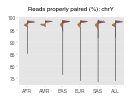

In [13]:
ax = sns.violinplot(x = "Superpopulation",
                    y = 'percentage of properly paired reads (%)',
                    hue="ref",
                    order=['AFR', 'AMR', 'EAS', 'EUR', 'SAS', 'ALL'],
                    palette=genome_palette,
                    data=full_cramstats_df,
                    split=True,
                    inner="quartile")

ax.set_title('Reads properly paired (%): chrY')
ax.set_ylabel('')
ax.set_xlabel('')
ax.legend_.remove()
plt.savefig(f'{figDir}/chrY.pct_reads_prop_paired.violin.all.unrelated.pdf')
plt.show()

#### Plotting (box)

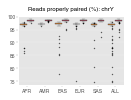

In [14]:
ax = sns.boxplot(x = "Superpopulation",
                    y = 'percentage of properly paired reads (%)',
                    hue="ref",
                    order=['AFR', 'AMR', 'EAS', 'EUR', 'SAS', 'ALL'],
                    palette=genome_palette,
                    data=full_cramstats_df,
                    flierprops=flierprops)

ax.set_title('Reads properly paired (%): chrY')
ax.set_ylabel('')
ax.set_xlabel('')
ax.legend_.remove()
plt.savefig(f'{figDir}/chrY.pct_reads_prop_paired.boxplot.all.unrelated.pdf')
plt.show()

### Mismatch Rate

#### Stats summary

In [15]:
stat = 'error rate (%)'
printCramStats(stat, CHM13v1_full_cramstats_df, CHM13v2_full_cramstats_df)

CHM13v1 mean reads mapped error rate (%): 0.9089546482562854
CHM13v1 stddev reads mapped error rate (%): 0.08141374958944464

CHM13v2 mean reads mapped error rate (%): 0.34620064209245743
CHM13v2 stddev reads mapped error rate (%): 0.058144390015914225

CHM13v2 - CHM13v1 mean error rate (%): -0.5627540061638281
CHM13v2 - CHM13v1 stddev error rate (%): 0.06253140018872733


#### Plotting

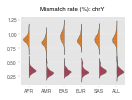

In [16]:
ax = sns.violinplot(x = "Superpopulation",
                    y = 'error rate (%)',
                    hue="ref",
                    order=['AFR', 'AMR', 'EAS', 'EUR', 'SAS', 'ALL'],
                    palette=genome_palette,
                    data=full_cramstats_df,
                    split=True,
                   inner='quartile')

ax.set_title('Mismatch rate (%): chrY')
ax.set_ylabel('')
ax.set_xlabel('')
ax.legend_.remove()
plt.savefig(f'{figDir}/chrY.mismatch_rate.all.unrelated.pdf')
plt.show()

# chrY Variant Calling Statistics

Variant calling stats were generated using `bcftools stats` with the final VCFs, subsetting to only the Y chromosome. This was done for both references.

In [17]:
def vcfstatsDF(file_name, ref):
    vcfstats_df = pd.DataFrame(columns=['sample_id', 'nRefHom', 'nNonRefHom', 'nHets', 'nTransitions', 'nTransversions', 'nIndels', 'average depth', 'nSingletons', 'nHapRef', 'nHapAlt', 'nMissing'])
    for line in open(file_name):
        if not line.startswith('PSC'):
            continue
        fields = line.rstrip('\n').split('\t')[2:]
        sample_info = [fields[0]] + [float(x) for x in fields[1:]]
        vcfstats_df.loc[len(vcfstats_df)] = sample_info
    
    vcfstats_df.set_index('sample_id', inplace=True)
    vcfstats_df['RefName'] = ref
    vcfstats_df['Superpopulation'] = sample_info_df.loc[XY_unrelated_samples, 'superpopulation']
    vcfstats_df['haplogroup'] = sample_info_df.loc[XY_unrelated_samples, 'Y_haplogroup']
    vcfstats_df['nVariants'] = vcfstats_df.loc[:, ['nNonRefHom', 'nHets', 'nIndels', 'nHapAlt']].sum(axis=1)
    
    return vcfstats_df

## chrY Full (full chromosome, no PAR, unrelated samples only)

In [18]:
CHM13v1_full_vcfstats_file = f"{dataDir}/vcfstats/chrY.CHM13v1.unrelated.bcftools.stats.txt"
CHM13v2_full_vcfstats_file = f"{dataDir}/vcfstats/chrY.CHM13v2.unrelated.bcftools.stats.txt"

CHM13v1_full_vcfstats_df = vcfstatsDF(CHM13v1_full_vcfstats_file, 'CHM13v1')
CHM13v2_full_vcfstats_df = vcfstatsDF(CHM13v2_full_vcfstats_file, 'CHM13v2')

full_vcfstats_df = pd.concat([CHM13v1_full_vcfstats_df, CHM13v2_full_vcfstats_df], axis=0)
full_vcfstats_df_copy = full_vcfstats_df.copy()
full_vcfstats_df_copy['Superpopulation'] = 'ALL'
full_vcfstats_df = pd.concat([full_vcfstats_df, full_vcfstats_df_copy], axis=0)

### Number of Variants (Superpopulation)

#### Plotting

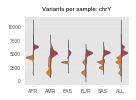

In [19]:
ax = sns.violinplot(x = "Superpopulation",
                    y = 'nVariants',
                    hue="RefName",
                    order=['AFR', 'AMR', 'EAS', 'EUR', 'SAS', 'ALL'],
                    palette=genome_palette,
                    data=full_vcfstats_df,
                    split=True,
                    inner="quartile")

ax.set_title('Variants per sample: chrY')
ax.set_ylabel('')
ax.set_xlabel('')
ax.legend_.remove()
plt.savefig(f'{figDir}/chrY.per-sample_variants.pops.all.unrelated.pdf')
plt.show()

## chrY Syntenic (syntenic regions only, no PAR, unrelated samples only)

In [20]:
CHM13v1_syntenic_vcfstats_file = f"{dataDir}/chrY_syntenic_variants/chrY.CHM13v1.unrelated.syntenic.bcftools.stats.txt"
CHM13v2_syntenic_vcfstats_file = f"{dataDir}/chrY_syntenic_variants/chrY.CHM13v2.unrelated.syntenic.bcftools.stats.txt"

CHM13v1_syntenic_vcfstats_df = vcfstatsDF(CHM13v1_syntenic_vcfstats_file, 'CHM13v1')
CHM13v2_syntenic_vcfstats_df = vcfstatsDF(CHM13v2_syntenic_vcfstats_file, 'CHM13v2')

syntenic_vcfstats_df = pd.concat([CHM13v1_syntenic_vcfstats_df, CHM13v2_syntenic_vcfstats_df], axis=0)
syntenic_vcfstats_df_copy = syntenic_vcfstats_df.copy()
syntenic_vcfstats_df_copy['Superpopulation'] = 'ALL'
syntenic_vcfstats_df = pd.concat([syntenic_vcfstats_df, syntenic_vcfstats_df_copy], axis=0)

### Number of Variants (Superpopulation)

#### Plotting

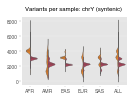

In [21]:
ax = sns.violinplot(x = "Superpopulation",
                    y = 'nVariants',
                    hue="RefName",
                    order=['AFR', 'AMR', 'EAS', 'EUR', 'SAS', 'ALL'],
                    palette=genome_palette,
                    data=syntenic_vcfstats_df,
                    split=True,
                    inner="quartile")

ax.set_title('Variants per sample: chrY (syntenic)')
ax.set_ylabel('')
ax.set_xlabel('')
ax.legend_.remove()
plt.savefig(f'{figDir}/chrY.per-sample_variants.pops.syntenic.unrelated.pdf')
plt.show()

### Number of Variants (Haplogroup)

#### Plotting (raw counts)

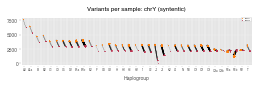

In [22]:
num_samples = CHM13v1_syntenic_vcfstats_df.shape[0]
sorted_haplogroups = sorted(set(CHM13v1_syntenic_vcfstats_df['haplogroup']))

fig, ax = plt.subplots(figsize=(90*mm,30*mm))

for i in range(num_samples):
    sample = CHM13v1_syntenic_vcfstats_df.index[i]
    haplogroup = CHM13v1_syntenic_vcfstats_df.loc[sample, 'haplogroup']
    CHM13v1_var_count = CHM13v1_syntenic_vcfstats_df.loc[sample, 'nVariants']
    CHM13v2_var_count = CHM13v2_syntenic_vcfstats_df.loc[sample, 'nVariants']
    x = sorted_haplogroups.index(haplogroup)
    jitter = np.random.normal(0, 0.05)
    x_v1 = x - 0.2 + jitter
    x_v2 = x + 0.2 + jitter
    ax.plot([x_v1, x_v2], [CHM13v1_var_count, CHM13v2_var_count], c='black', zorder=1, lw=0.1)
    ax.scatter([x_v1], [CHM13v1_var_count], c=genome_palette['CHM13v1'], zorder=2, label='CHM13v1', s=0.2)
    ax.scatter([x_v2], [CHM13v2_var_count], c=genome_palette['CHM13v2'], zorder=2, label='CHM13v2', s=0.2)

ax.set_xticks([i for i in range(len(sorted_haplogroups))])
ax.set_xticklabels(sorted_haplogroups, fontsize=3)

for i in range(len(ax.get_xticklabels())-1):
    current_x = ax.get_xticklabels()[i].get_position()[0]
    next_x = ax.get_xticklabels()[i+1].get_position()[0]
    avg_x = np.mean([current_x, next_x])
    ax.axvline(x=avg_x, c='white', lw=0.4)

ax.set_title('Variants per sample: chrY (syntentic)')
ax.set_xlabel('Haplogroup')
ax.set_ylabel('')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(sorted(zip(labels, handles), key=lambda x: x[0]))
ax.legend(by_label.values(), by_label.keys(), facecolor='white', loc='upper right')
ax.set_xlim([-0.5, len(sorted_haplogroups)-0.5])
plt.tight_layout()
fig.savefig(f'{figDir}/chrY.per-sample_variants.haplogroups.syntenic.unrelated.pdf')
plt.show()

#### Plotting (delta)

In [23]:
chrY_syntenic_variants_diff_df = CHM13v1_syntenic_vcfstats_df.loc[:, ['haplogroup', 'Superpopulation']].copy()
chrY_syntenic_variants_diff_df['delta_variants'] = CHM13v2_syntenic_vcfstats_df['nVariants'] - CHM13v1_syntenic_vcfstats_df['nVariants']

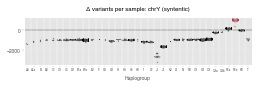

In [24]:
colors = ["#AA4455" if hap == 'R1b' else  "#000000" for hap in sorted_haplogroups]

fig, ax = plt.subplots(figsize=(90*mm,30*mm))
sns.swarmplot(x='haplogroup', y='delta_variants',
              data=chrY_syntenic_variants_diff_df,
              order=sorted_haplogroups,
              palette=dict(zip(sorted_haplogroups, colors)),
              ax=ax,
              s=0.8,
              dodge=True)

ax.set_xticks([i for i in range(len(sorted_haplogroups))])
ax.set_xticklabels(sorted_haplogroups, fontsize=3)
    
for i in range(len(ax.get_xticklabels())-1):
    current_x = ax.get_xticklabels()[i].get_position()[0]
    next_x = ax.get_xticklabels()[i+1].get_position()[0]
    avg_x = np.mean([current_x, next_x])
    ax.axvline(x=avg_x, c='white', lw=0.4, zorder=2)

ax.axhline(y=0, c='black', lw=0.3, zorder=1)
ax.set_ylabel('')
ax.set_title('Δ variants per sample: chrY (syntentic)')
ax.set_xlabel('Haplogroup')
plt.tight_layout()
fig.savefig(f'{figDir}/chrY.per-sample_variants_diff.swarmplot.haplogroups.syntenic.unrelated.pdf')
plt.show()

# chrX PAR Variant Calling Statistics

As before, variant calling stats were generated using `bcftools stats` with the final VCFs, subsetting to only the X PAR region. This was done for both references.

On CHM13v1, XY samples were called as haploid in the chrX PAR. Because of the way `bcftools stats` handles hemizygous indels, these variants are included in the counts of `hap` variants.  The PSI section is empty for haploid regions.

On CHM13v2 howver, XY samples were called as diploid in the chrX PAR. Now, information about indels is in the PSI field, and so we have a separate function for counting indels for diploid regions.

In [28]:
def vcfstatsIndelDF(file_name, ref):
    vcfstats_df = pd.DataFrame(columns=['sample_id', 'in-frame', 'out-frame', 'not applicable', 'out/(in+out) ratio', 'nInsHets', 'nDelHets', 'nInsAltHoms', 'nDelAltHoms'])
    for line in open(file_name):
        if not line.startswith('PSI'):
            continue
        fields = line.rstrip('\n').split('\t')[2:]
        sample_info = [fields[0]] + [float(x) for x in fields[1:]]
        vcfstats_df.loc[len(vcfstats_df)] = sample_info
    
    vcfstats_df.set_index('sample_id', inplace=True)
    vcfstats_df['RefName'] = ref
    vcfstats_df['Superpopulation'] = sample_info_df.loc[XY_unrelated_samples, 'superpopulation']
    vcfstats_df['haplogroup'] = sample_info_df.loc[XY_unrelated_samples, 'Y_haplogroup']
    vcfstats_df['nHets'] = vcfstats_df.loc[:, ['nInsHets', 'nDelHets']].sum(axis=1)
    vcfstats_df['nAltHoms'] = vcfstats_df.loc[:, ['nInsAltHoms', 'nDelAltHoms']].sum(axis=1)
    
    return vcfstats_df

## chrX PAR (unrelated XY samples only)

### Number of variants

In [26]:
CHM13v1_PAR_vcfstats_file = f"{dataDir}/chrX_PAR_regions/chrX.CHM13v1.unrelated.PAR.bcfstats.txt"
CHM13v2_PAR_vcfstats_file = f"{dataDir}/chrX_PAR_regions/chrX.CHM13v2.unrelated.PAR.bcfstats.txt"

CHM13v1_PAR_vcfstats_df = vcfstatsDF(CHM13v1_PAR_vcfstats_file, 'CHM13v1').loc[XY_unrelated_samples, :]
CHM13v2_PAR_vcfstats_df = vcfstatsDF(CHM13v2_PAR_vcfstats_file, 'CHM13v2').loc[XY_unrelated_samples, :]

CHM13v2_PAR_indel_vcfstats_df = vcfstatsIndelDF(CHM13v2_PAR_vcfstats_file, 'CHM13v2').loc[XY_unrelated_samples, :]

PAR_vcfstats_df = pd.concat([CHM13v1_PAR_vcfstats_df, CHM13v2_PAR_vcfstats_df], axis=0)

#### Plotting

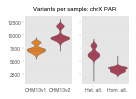

In [27]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)

sns.violinplot(x = "RefName",
               y = 'nVariants',
               palette=genome_palette,
               data=PAR_vcfstats_df,
               inner="quartile",
               ax=ax1)

sns.violinplot(data=[CHM13v2_PAR_vcfstats_df['nHets']+CHM13v2_PAR_indel_vcfstats_df['nHets'], CHM13v2_PAR_vcfstats_df['nNonRefHom']+CHM13v2_PAR_indel_vcfstats_df['nAltHoms']],
               inner="quartile",
               color=chm13_v2_color,
               ax=ax2)

ax2.set_xticklabels(['Het. alt.', 'Hom. alt.'])

fig.suptitle('Variants per sample: chrX PAR')
ax1.set_ylabel('')
ax1.set_xlabel('')
plt.savefig(f'{figDir}/chrX.per-sample_variants.PAR.unrelated.pdf')
plt.show()